In [101]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import pyfolio as pf

plt.style.use('bmh')

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [241]:
def ewma_vol(returns,
             bdays,
             multiply_factor=100,
             annualize=True) -> pd.DataFrame:
    if annualize:
        ann_factor = 252
    else:
        ann_factor = 1
        
    r_vol = multiply_factor * np.sqrt(returns.ewm(span=bdays, adjust=False).var()) * np.sqrt(ann_factor)
    return r_vol

In [292]:
latam_data = pd.read_excel(os.path.join("data", "fx_fair_value_data.xlsx"), engine='openpyxl', sheet_name="LATAM")
latam_data.rename(columns={"Dates": "date"}, inplace=True)
latam_data["date"] = pd.to_datetime(latam_data["date"])
latam_data.set_index("date", inplace=True)
try:
    latam_data.drop(["USDMYR Curncy", "USDINR Curncy", "USDCNY Curncy"], axis=1, inplace=True)
except:
    pass
latam_data.head()

TARGET = "USDCOP Curncy"

In [293]:
zscore_latam_data = latam_data.apply(lambda x: (x - x.mean()) / x.std())
zscore_latam_data.head()

,USDBRL Curncy,USDCOP Curncy,USDCLP Curncy,USDMXN Curncy,USDZAR Curncy
date,,,,,
2000-01-03,-0.934584,-1.059208,-0.806684,-1.139026,-1.191636
2000-01-04,-0.904841,-1.034502,-0.791884,-1.122143,-1.204248
2000-01-05,-0.915995,-1.005677,-0.785985,-1.122220,-1.210813
2000-01-06,-0.913671,-1.001724,-0.817034,-1.119928,-1.207652
2000-01-07,-0.927148,-1.020501,-0.842390,-1.123748,-1.214125


<AxesSubplot:xlabel='date'>

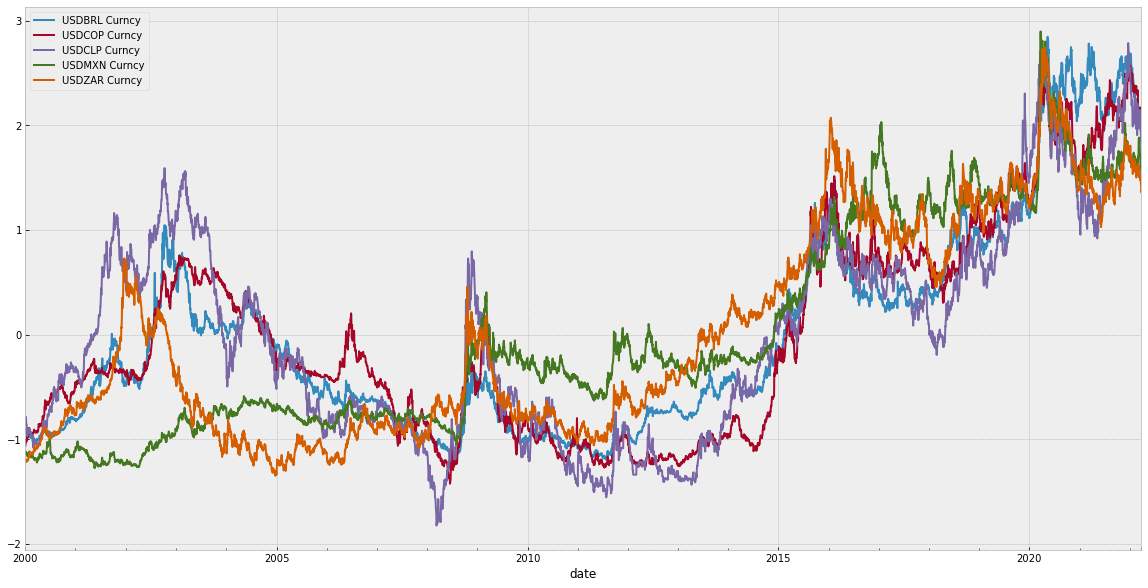

In [294]:
zscore_latam_data.plot(figsize=(20, 10))

## 1. Cointegration model with look ahead bias: KRW

In [295]:
coint_model = sm.OLS(endog=zscore_latam_data[[TARGET]],
                     exog=zscore_latam_data.drop(TARGET, axis=1))
fit_coint_model = coint_model.fit()
fit_coint_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          USDCOP Curncy   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                          2.537e+04
Date:                Sun, 27 Mar 2022   Prob (F-statistic):                        0.00
Time:                        16:01:31   Log-Likelihood:                          233.04
No. Observations:                5800   AIC:                                     -458.1
Df Residuals:                    5796   BIC:                                     -431.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
USDBRL Curncy     0.5306      0.009     56.105      0.000       0.512       0.549
USDCLP Curncy     0.4616      0.008     56.910      0.000       0.446       0.477
USDMXN Curncy     0.3110      0.008     37.526      0.000       0.295       0.327
USDZAR Curncy    -0.2824      0.008    -33.323      0.000      -0.299      -0.266
==============================================================================
Omnibus:                      206.054   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.324
Skew:                           0.136   Prob(JB):                     1.35e-23
Kurtosis:                       2.398   Cond. No.                         8.40
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='date'>

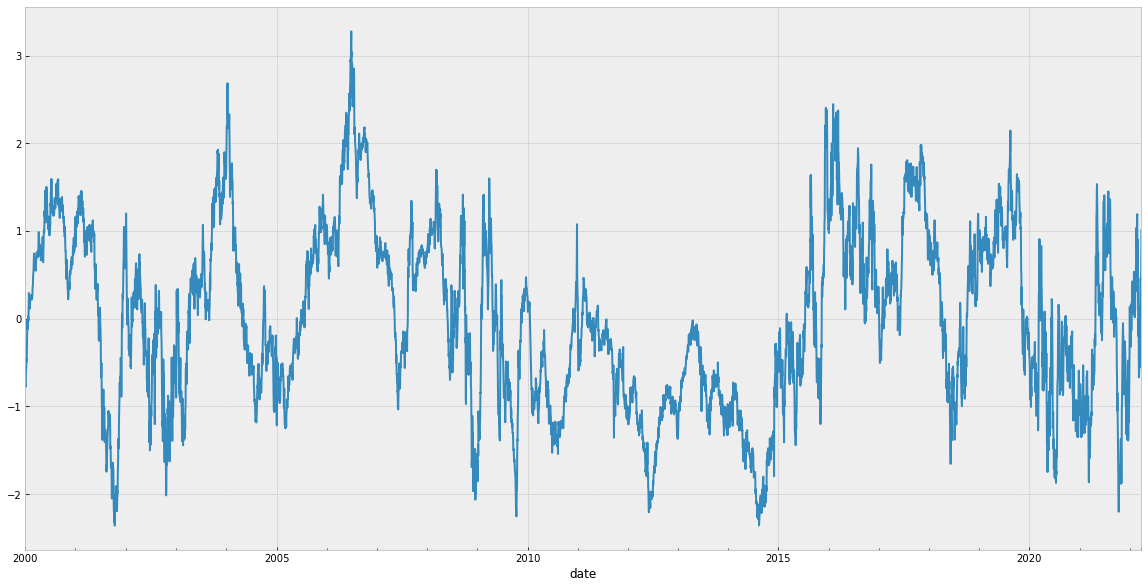

In [296]:
((fit_coint_model.resid - fit_coint_model.resid.mean()) / fit_coint_model.resid.std()).plot(figsize=(20, 10))

## 2. Cointegration model without look ahead bias: BRL

In [297]:
rollingmean_latam_data = latam_data.rolling(window=252, min_periods=252).mean()
rollingstd_latam_data = latam_data.rolling(window=252, min_periods=252).std()

rollingzscore_latam_data = (latam_data.subtract(rollingmean_latam_data, axis=0)).divide(rollingstd_latam_data, axis=0).dropna()

<AxesSubplot:xlabel='date'>

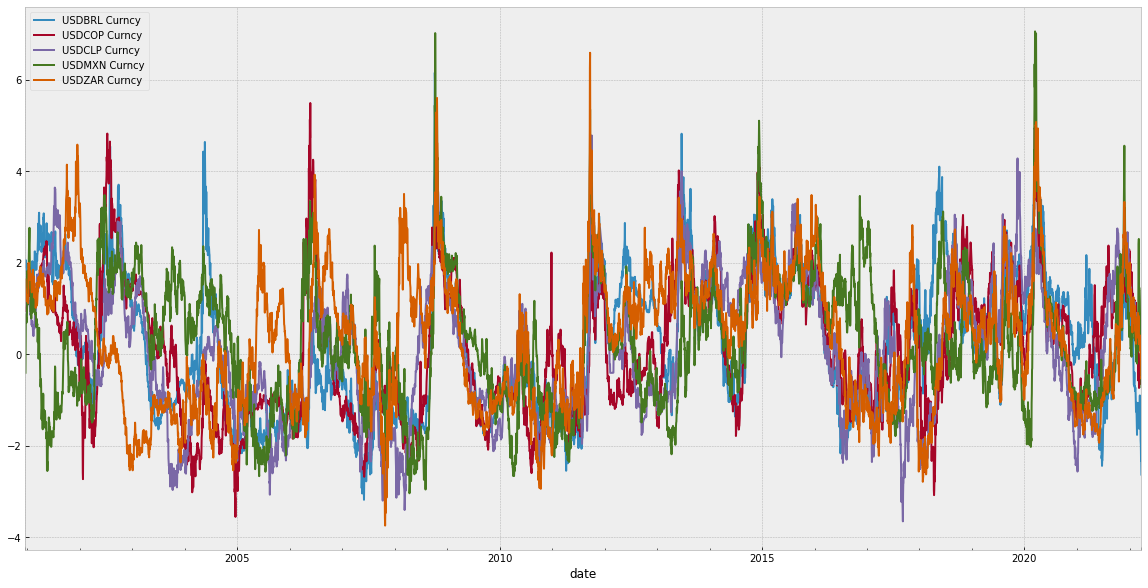

In [298]:
rollingzscore_latam_data.plot(figsize=(20, 10))

<AxesSubplot:xlabel='date'>

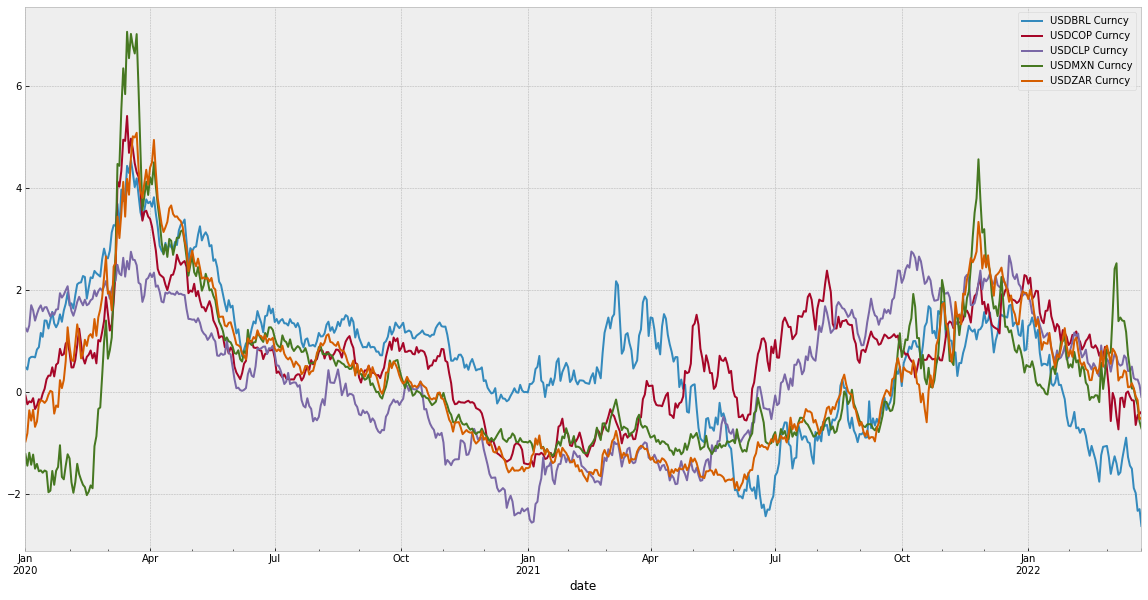

In [299]:
rollingzscore_latam_data.loc["2020-01-01":].plot(figsize=(20, 10))

In [300]:
coint_model = sm.OLS(endog=rollingzscore_latam_data[[TARGET]],
                     exog=rollingzscore_latam_data.drop(TARGET, axis=1))
fit_coint_model = coint_model.fit()
fit_coint_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          USDCOP Curncy   R-squared (uncentered):                   0.577
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              1888.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):                        0.00
Time:                        16:01:43   Log-Likelihood:                         -7591.1
No. Observations:                5549   AIC:                                  1.519e+04
Df Residuals:                    5545   BIC:                                  1.522e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
USDBRL Curncy     0.2170      0.013     17.116      0.000       0.192       0.242
USDCLP Curncy     0.3858      0.013     29.240      0.000       0.360       0.412
USDMXN Curncy     0.2177      0.011     20.429      0.000       0.197       0.239
USDZAR Curncy     0.0938      0.011      8.595      0.000       0.072       0.115
==============================================================================
Omnibus:                      173.956   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.032
Skew:                           0.271   Prob(JB):                     3.17e-65
Kurtosis:                       3.995   Cond. No.                         2.97
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [301]:
resid_fit_coint_model = fit_coint_model.resid
rollingmean_resid_fit_coint_model = resid_fit_coint_model.rolling(window=252, min_periods=252).mean()
rollingstd_resid_fit_coint_model = resid_fit_coint_model.rolling(window=252, min_periods=252).std()

zscore_resid_fit_coint_model = (resid_fit_coint_model.subtract(rollingmean_resid_fit_coint_model, axis=0)).divide(rollingstd_resid_fit_coint_model, axis=0)

<AxesSubplot:xlabel='date'>

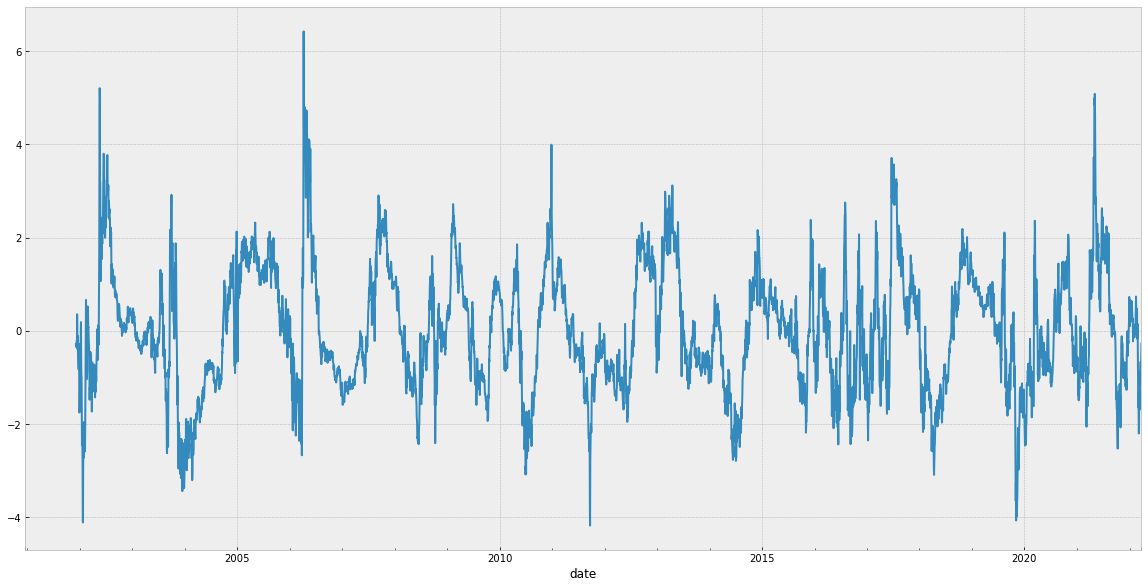

In [302]:
zscore_resid_fit_coint_model.plot(figsize=(20, 10))

In [303]:
adfuller(fit_coint_model.resid)

(-6.3474271564874485,
 2.6616302368331002e-08,
 5,
 5543,
 {'1%': -3.431530287012324,
  '5%': -2.8620615704761816,
  '10%': -2.5670476306630508},
 -3076.200324561072)

In [304]:
predict = pd.DataFrame((fit_coint_model.predict() * rollingstd_latam_data[TARGET].dropna()) + rollingmean_latam_data[TARGET].dropna())
predict.columns = [TARGET + " fit"]

predict_plot_df = pd.concat([predict, latam_data[[TARGET]]], axis=1)

<AxesSubplot:xlabel='date'>

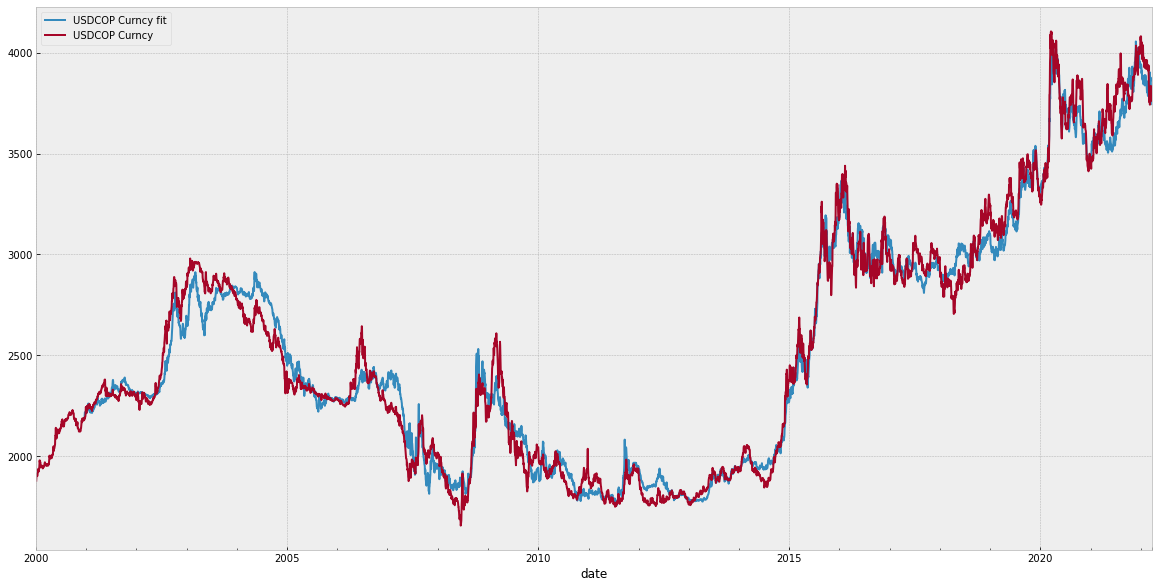

In [305]:
predict_plot_df.plot(figsize=(20, 10))

In [306]:
rolling_coint_model = RollingOLS(endog=rollingzscore_latam_data[[TARGET]],
                                 exog=rollingzscore_latam_data.drop(TARGET, axis=1),
                                 window=252*10)
fit_rolling_coint_model = rolling_coint_model.fit()

<AxesSubplot:xlabel='date'>

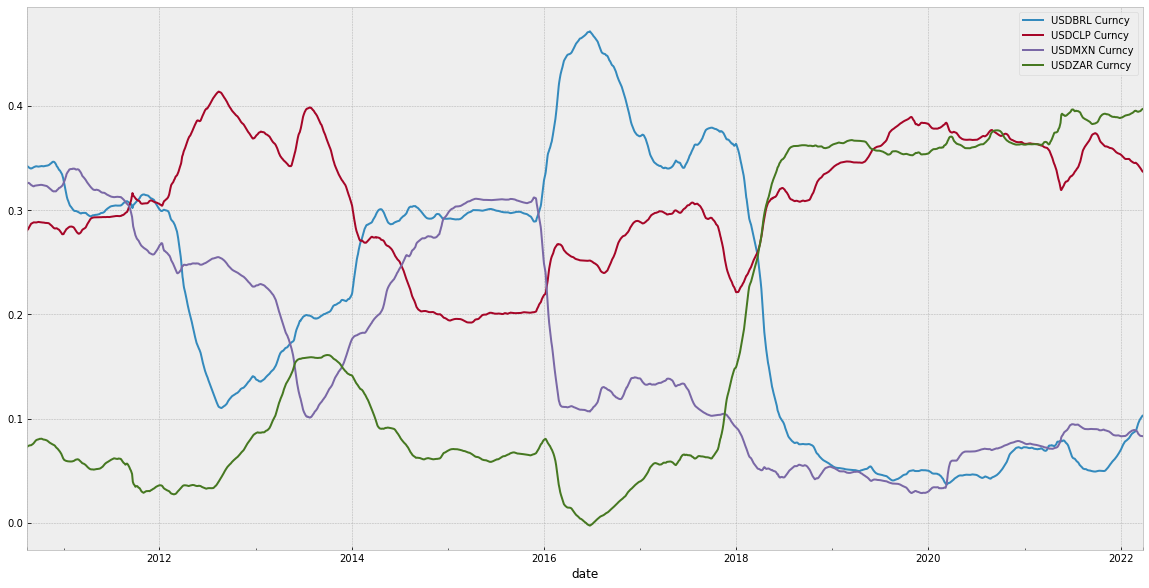

In [307]:
fit_rolling_coint_model.params.dropna().plot(figsize=(20, 10))

In [308]:
rolling_coefficients = fit_rolling_coint_model.params.dropna()

In [309]:
bars_df = latam_data.copy()
vol_target = 0.1
vols = ewma_vol(returns=latam_data.pct_change(),
                bdays=22,
                multiply_factor=1)
signal = pd.DataFrame(np.where(zscore_resid_fit_coint_model > 2,
                               -1,
                               np.where(zscore_resid_fit_coint_model < -2,
                                        1,
                                        0)),
                      index=zscore_resid_fit_coint_model.index,
                      columns=[TARGET])

In [310]:
positions = signal.multiply(vol_target / vols.shift(1), axis=0)
portfolio_endog = positions.shift(1).multiply(bars_df.pct_change(), axis=0).dropna(axis=1, how="all")

<AxesSubplot:xlabel='date'>

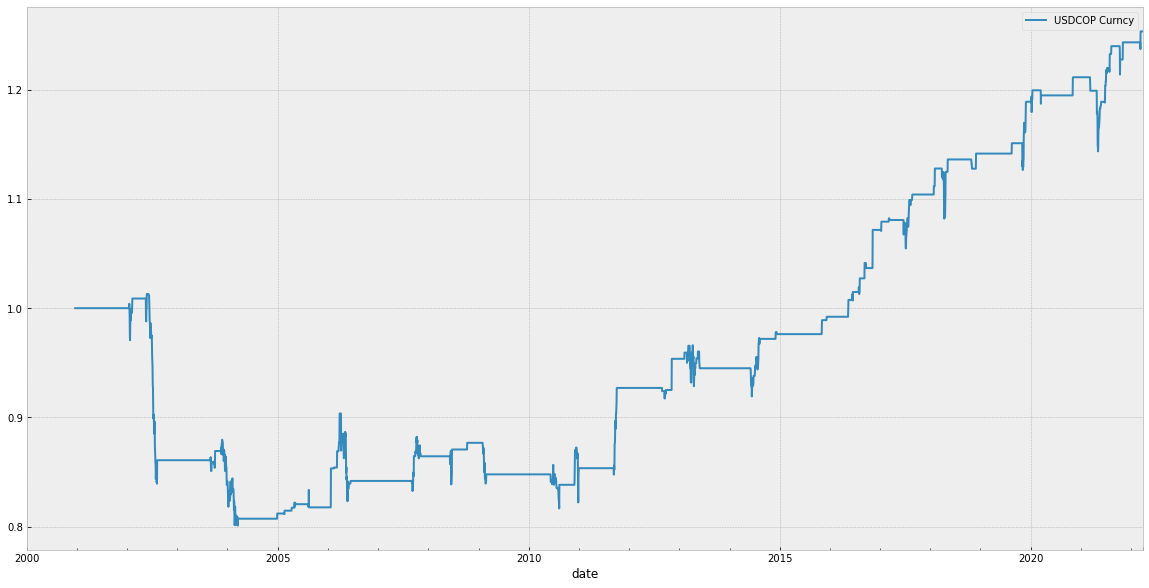

In [311]:
(1+portfolio_endog).cumprod().plot(figsize=(20, 10))

In [314]:
signal_endog = []
names = []
for col in latam_data.columns:
    if col == TARGET:
        continue
    else:
        signal_endog.append(signal * -1)
        names.append(col)
signal_endog = pd.concat(signal_endog, axis=1)
signal_endog.columns = names

positions_endog = signal_endog.multiply(vol_target / vols.shift(1), axis=0)
portfolio_exog = positions_endog.shift(1).multiply(bars_df.pct_change(), axis=0).dropna(axis=1, how="all")

<AxesSubplot:xlabel='date'>

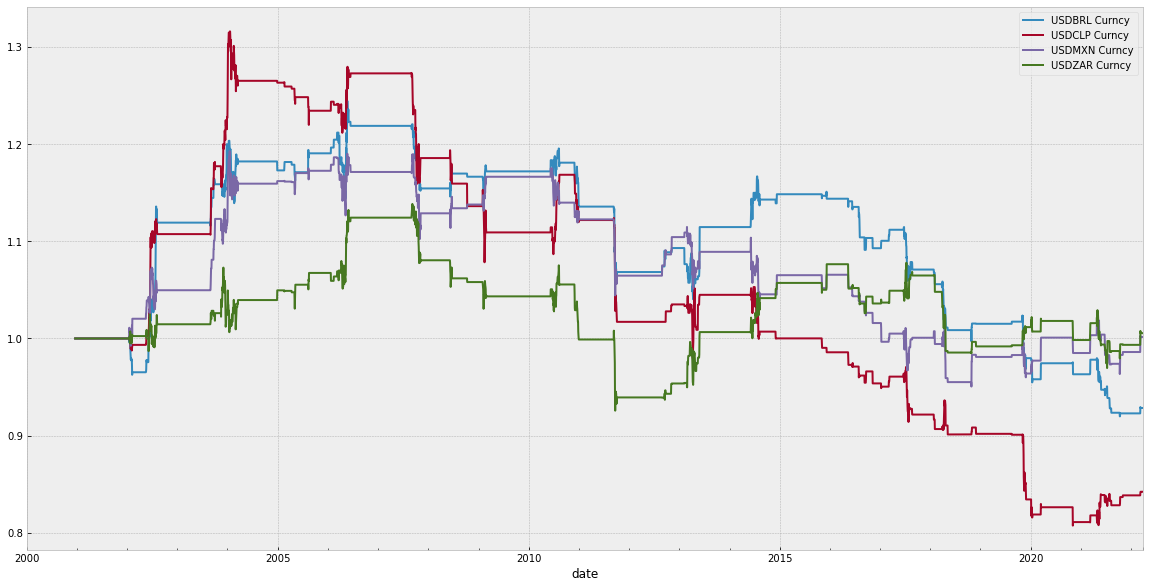

In [315]:
(1+portfolio_exog).cumprod().plot(figsize=(20, 10))

<AxesSubplot:xlabel='date'>

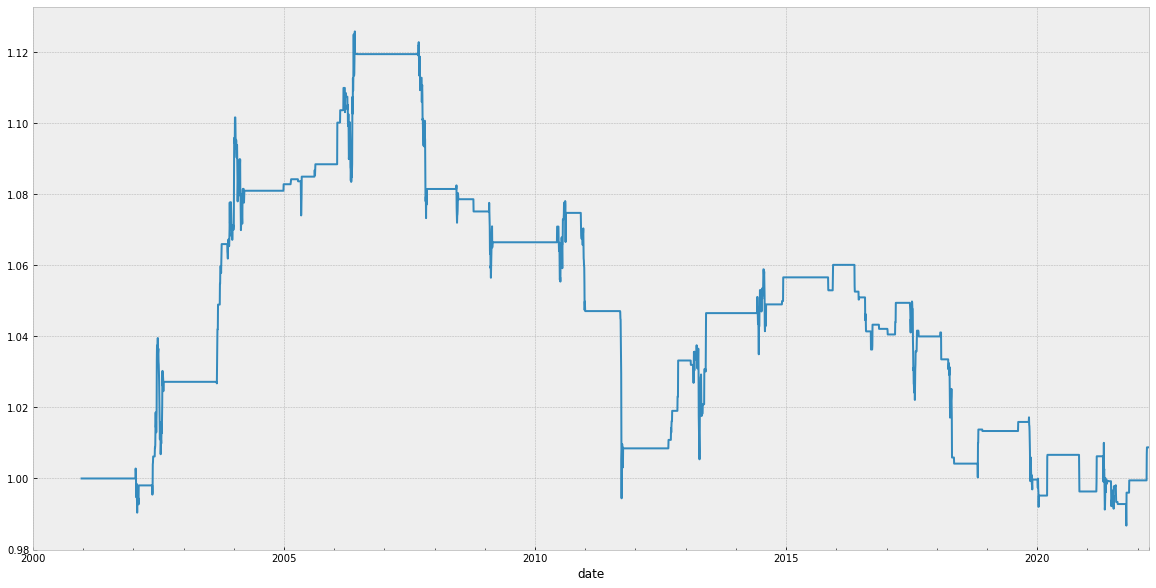

In [316]:
portfolio = pd.concat([portfolio_endog, portfolio_exog], axis=1)
(1+portfolio.mean(axis=1)).cumprod().plot(figsize=(20, 10))

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.6/site-packages/empyrical/stats.py:1528: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2000-12-20
End date,2022-03-25
Total months,264
,Backtest
Annual return,0.9%
Cumulative returns,21.7%
Annual volatility,1.9%
Sharpe ratio,0.47
Calmar ratio,0.21
Stability,0.91
Max drawdown,-4.2%


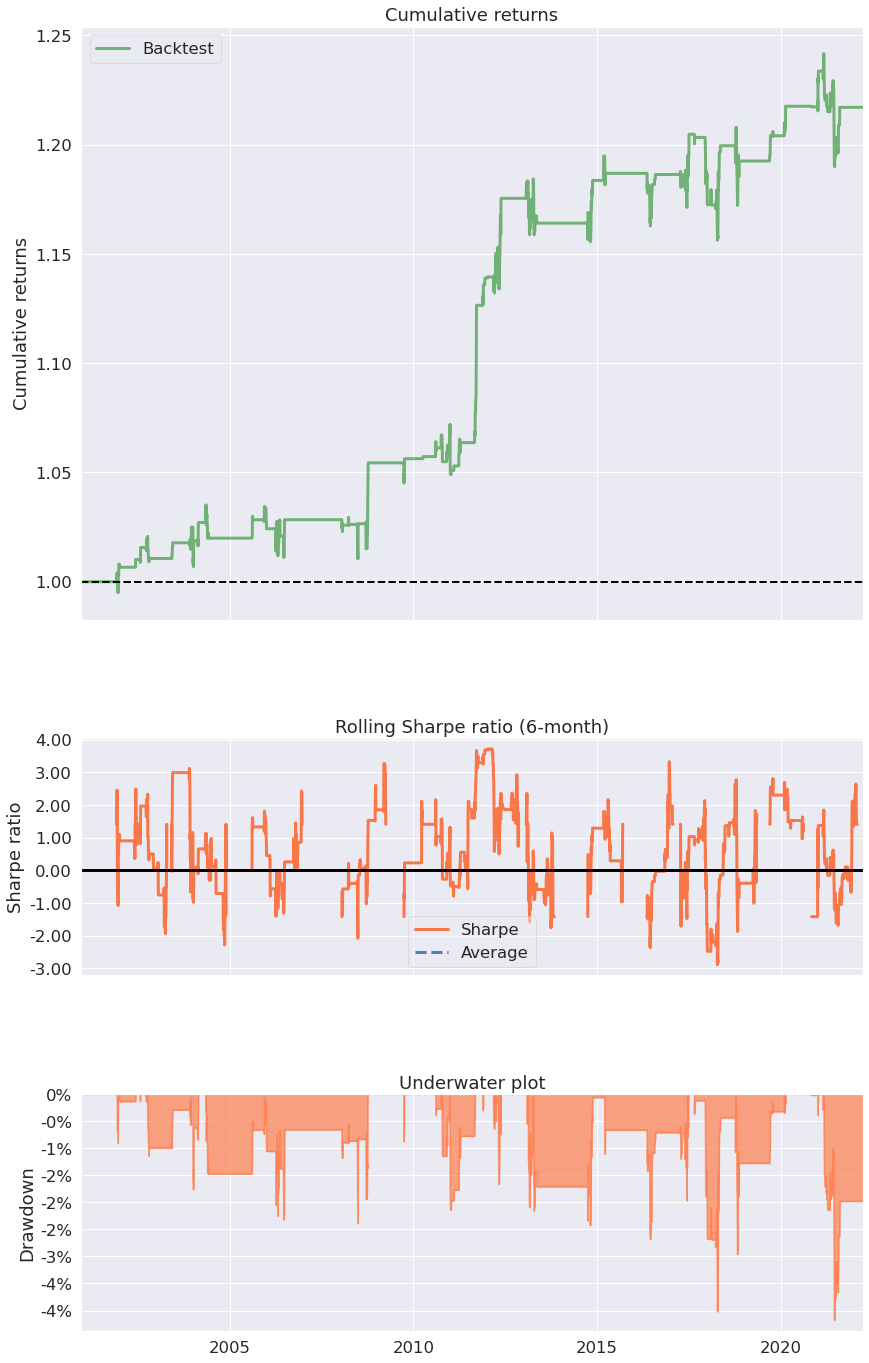

In [257]:
pf.create_simple_tear_sheet(portfolio.mean(axis=1).dropna())